# Visualize feature performace at the chat level
Directions:
1. Run feature on datasets (python3 featurize.py)
2. Input feature name (column name), dataset, and number of chunks for which you wish to visualize the feature. 
3. 2 generated charts: First is grayscale, darker corresponds to lower values of performance. Second is above/below mean, green is above mean, red is below mean. 

In [29]:
# VISUALIZATION IMPLEMENTATION
import numpy as np
from matplotlib import pyplot as plt, colors
import pandas as pd
from assign_chunk_nums import *
from scipy import stats
import math

target_dict = {"jury": "majority_pct", "csop": "zscore_efficiency", "csopII": "efficiency", "beckerestimation": "mean_post_discussion_error_pct", "dat": "score"}

def max_chunks_screening(df, max_chunks):
    if (len(df) == max_chunks):
        return df

def get_feature_data(feature, dataset, chunks):
    chat_fields = ['conversation_num', feature]
    chat_df = pd.read_csv('../output/' + dataset + '_output_chat_level.csv', skipinitialspace=True, usecols=chat_fields)
    
    chunked_df = assign_chunk_nums(chat_df, chunks)

    # average feature values
    avg_chunked_df = chunked_df.groupby(['conversation_num', 'chunk_num']).apply(lambda x: x[feature].mean())
    avg_chunked_df = avg_chunked_df.to_frame().rename(columns={0:feature})
    
    # formatting
    avg_chunked_df = avg_chunked_df.reset_index()
    avg_chunked_df['chunk_num_plt'] = avg_chunked_df.groupby('conversation_num').cumcount() + 1

    full_df = avg_chunked_df.groupby(['conversation_num']).apply(lambda x: max_chunks_screening(x, chunks))

    return full_df.reset_index(drop=True)


def get_target_data(feature, dataset):
    conv_fields = ['conversation_num', target_dict[dataset]]

    # parse feature results from output data
    target_df = pd.read_csv('../output/' + dataset + '_output_conversation_level.csv', skipinitialspace=True, usecols=conv_fields)


    # parse target results into workable np array
    np_arr = target_df[target_dict[dataset]].to_numpy()
    np_arr[np.isnan(np_arr)] = 0

    # min max normalization
    normalized = (np_arr-np.min(np_arr))/(np.max(np_arr)-np.min(np_arr))

    # zscore standardization
    zscored = stats.zscore(np_arr)

    # concat to dataframe
    target_df['norm'] = pd.Series(normalized)
    target_df['zscore'] = pd.Series(zscored)
    return target_df


def plot_gradient_results(data, df_label, category, chunks):

    plt.figure(figsize=(12, 6))
    for conversation_num, group in data.groupby('conversation_num'):
        plt.plot(group['chunk_num_plt'], group[category], label=f'Conversation {conversation_num}', color=str(group['norm'].iloc[0]))

    xticks = range(1, chunks + 1)
    plt.xlabel(f'Chunk Number (Each contains 1/{chunks} of chats)')
    plt.xticks(xticks)
    plt.ylabel(f'average {category}')
    plt.title(f'{df_label} {category} over time')
    # print(category)
    plt.show()

def plot_rg_results(data, df_label, category, chunks, zscoreSplit, isMedian = False):
	
    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots()

    zscoreSplit = data['zscore'].median() if isMedian else zscoreSplit
    # print(f'Zscore: {zscoreSplit}')
    for conversation_num, group in data.groupby('conversation_num'):
        color = 'r' if group['zscore'].iloc[0] < zscoreSplit else 'g'
        plt.plot(group['chunk_num_plt'], group[category], label=f'Conversation {conversation_num}', color=color, alpha=0.3)

    # ADDING AVERAGE LINES
    chunk_values = [[]*3 for i in range(chunks)] 
    
    for chunk_num_plt, group in  data.loc[:,['zscore', category, 'chunk_num_plt']].groupby('chunk_num_plt'):
            sorted = (group.sort_values(by=['zscore'])) # per chunk across all conversations

            # MEDIAN LINES            
            # chunk_values[chunk_num_plt - 1] = [sorted[category].iloc[round(0.25*len(group))], sorted[category].iloc[round(0.5*len(group))], sorted[category].iloc[round(0.75*len(group))]]
            # print(f'Chunk {chunk_num_plt}: {sorted}')
            
            # MEAN LINES
            chunk_values[chunk_num_plt - 1] = [sorted[category].head(round(0.5*len(group))).mean(), sorted[category].mean(), sorted[category].tail(round(0.5*len(group))).mean()]
            # print(chunk_values)

    xticks = range(1, chunks + 1)
    chunk_values_t = np.array(chunk_values).T.tolist()
    labels = ["bottom 50", "avg", "top 50"]
    ymin, ymax = ax.get_ylim()
    yrange = ymax-ymin

    for line, label in zip(chunk_values_t, labels):
        plt.plot(xticks, line, color='k', zorder=20)
        plt.text(xticks[0], line[0] + (yrange/40), label)


    plt.xlabel(f'Chunk Number (Each contains 1/{chunks} of chats)')
    plt.xticks(xticks)
    plt.ylabel(f'average {category}')
    plt.title(f'{df_label} {category} over time')
    # print(category)
    plt.show()

def visualize(feature, dataset, chunks, zscoreSplit, isMedian = False):

    data_to_plot = pd.merge(
            left=get_feature_data(feature, dataset, chunks),
            right=get_target_data(feature, dataset),
            on=['conversation_num'],
            how="inner"
        )
    
    plot_rg_results(data_to_plot, dataset, feature, chunks, zscoreSplit, isMedian)
    plot_gradient_results(data_to_plot, dataset, feature, chunks)



In [30]:
import matplotlib.patches as mpatches

color_dict = {"jury": ("r", "g"), "csop": ("y", "b"), "csopII": ("c", "#FFA500"), "becker": ("b", "#800080"), "dat": ("r", "g")}

def plot_df_results(data_df, data_labels, category, chunks, zscoreSplit, isMedian = False):

    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots()
    color_patches = []


    for df, label in zip(data_df, data_labels):
        color_tpl = color_dict[label]
        zscoreSplit = df['zscore'].median() if isMedian else zscoreSplit

        color_patches.append(mpatches.Patch(color=color_tpl[1], label= f'{label} above {round(zscoreSplit, 2)}'))
        color_patches.append(mpatches.Patch
        (color=color_tpl[0], label= f'{label} below {round(zscoreSplit, 2)}'))

        plt.plot()
        
        for conversation_num, group in df.groupby('conversation_num'):
            color = color_tpl[0] if group['zscore'].iloc[0] < zscoreSplit else color_tpl[1]


            plt.plot(group['chunk_num_plt'], group[category], label=f'Conversation {conversation_num}', color=color, alpha=0.3, zorder=-10)
        
        ymin, ymax = ax.get_ylim()
        yrange = ymax-ymin
        # print(f'yrange {yrange}')
        # adding AVERAGE line
        avg_df = df.loc[:,[category, 'chunk_num_plt']].groupby('chunk_num_plt').mean().reset_index()
        plt.plot(avg_df['chunk_num_plt'], avg_df[category], color='k', zorder=20)
        plt.text(avg_df['chunk_num_plt'].iloc[-3], avg_df[category].iloc[-3] + (yrange/20), label)

    plt.rcParams.update({'font.size': 10})
    plt.xticks([1, 2, 3])
    plt.xlabel(f'Chunk Number (Each contains 1/{chunks} of chats)')
    plt.ylabel(f'average {category}')
    plt.title(category + ' over time')
    ax.legend(handles=color_patches)
    plt.show()

def visualize_arr(feature, datasets, chunks, zscoreSplit, isMedian = False):

    data_arr_to_plot = [pd.merge(
            left=get_feature_data(feature, dataset, chunks),
            right=get_target_data(feature, dataset),
            on=['conversation_num'],
            how="inner"
        ) for dataset in datasets]
    
    plot_df_results(data_arr_to_plot, datasets, feature, chunks, zscoreSplit, isMedian)


## Calling the Visualization

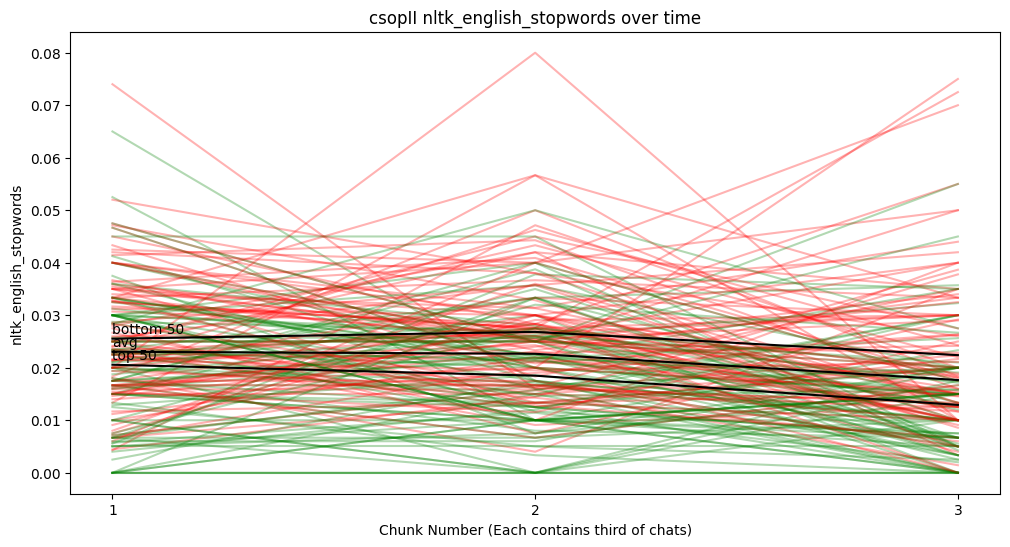

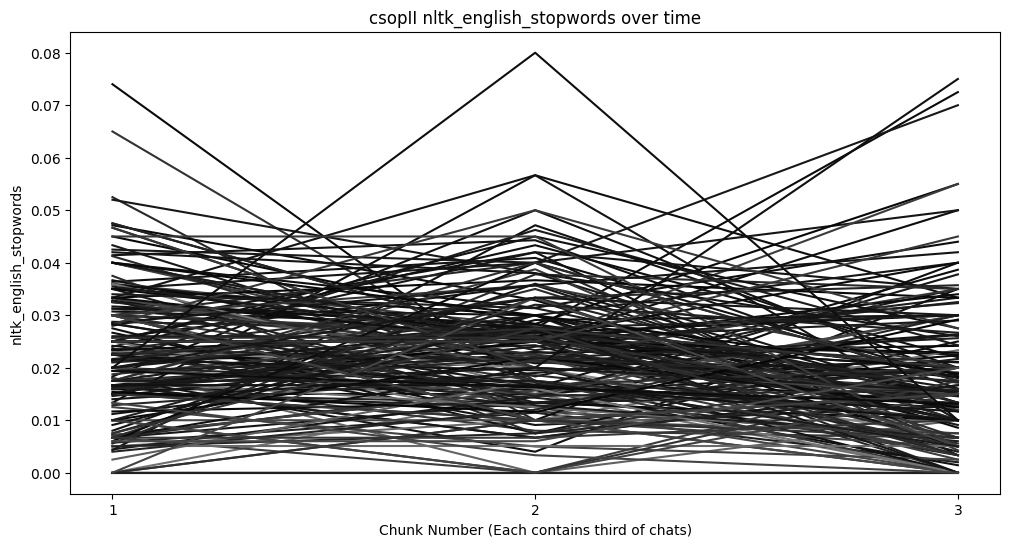

In [8]:
# SINGLE
visualize('nltk_english_stopwords','csopII', 3, zscoreSplit=0, isMedian=True)

yrange 0.551790612692647
yrange 1.0590632494749999


<Figure size 1200x600 with 0 Axes>

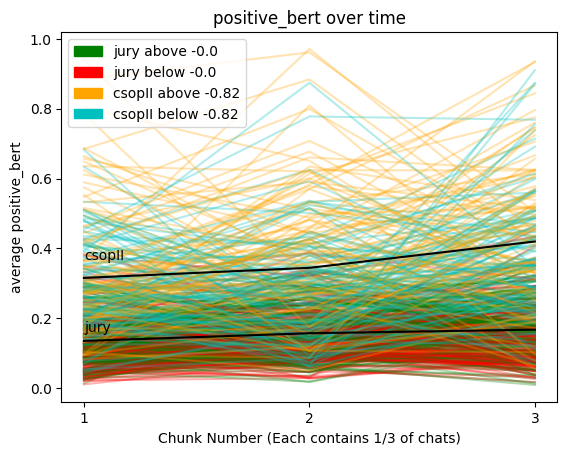

In [32]:
# CALL YOUR VISUALIZATION
# SINGLE
# visualize('positive_bert','csopII', 3, zscoreSplit=0, isMedian=True)

# MULTIPLE
visualize_arr('positive_bert', ['jury', 'csopII'], 3, zscoreSplit=0, isMedian=True)